## Optuna (AQT)

In [3]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))

In [11]:
from qiskit_aqt_provider import AQTProvider
aqt = AQTProvider('6f47670f3e5c414da0cdcab1c048eb97')
print(aqt.backends())
simulator_backend = aqt.backends.aqt_qasm_simulator

[<AQTSimulator('aqt_qasm_simulator')>, <AQTSimulatorNoise1('aqt_qasm_simulator_noise_1')>, <AQTDevice('aqt_innsbruck')>]
{'00': 52, '11': 48}


In [5]:
import optuna
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA

from shared.graph_helper import *
from shared.QiskitMaxcut import *
from aqt.aqt_parameters import *

%matplotlib inline

In [14]:

quantum_instance = QuantumInstance(
                    backend=simulator_backend,
                    shots=SHOTS)

qaoa = QAOA(optimizer=SPSA(maxiter=1), quantum_instance=quantum_instance, reps=1,
               initial_point=[0.,1.])

MinimumEigenOptimizer(qaoa).solve(max_cut_qubo)



/Users/lachermeier/.pyenv/versions/3.8.10/lib/python3.8/site-packages/qiskit/utils/deprecation.py:56: UserWarning: Option max_credits is not used by this backend
  return func(*args, **kwargs)
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qo

KeyboardInterrupt: 

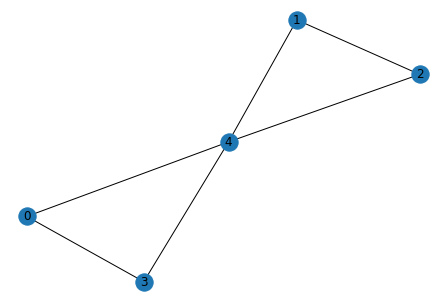

In [12]:
# ---- Define graph and MaxCut ----
graph = generate_butterfly_graph(with_weights=True)
#graph = load_nx_graph_from("../data/graphs/04_nodes/graph_04_04_03_w.txt")
max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()


In [7]:
def init_qaoa(optimizer, reps, init_parameters):
    quantum_instance = QuantumInstance(
                    backend=simulator_backend,
                    shots=SHOTS)

    qaoa = QAOA(optimizer=optimizer, quantum_instance=quantum_instance, reps=reps, 
               initial_point=init_parameters) 
    
    return qaoa

In [8]:
def run(max_cut_problem, qaoa):
    # Run quantum algorithm QAOA
    algorithm = MinimumEigenOptimizer(qaoa)
    result = algorithm.solve(max_cut_problem)
    optimal_parameters = qaoa.optimal_params
    
    return result, optimal_parameters.copy()

In [9]:
def objective(trial):
    optimizer_name = trial.suggest_categorical("optimizer", optimizers.keys())
    reps = trial.suggest_int('reps', REPS_MIN, REPS_MAX + 1)
    parameters = []
    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'gamma_{i}', GAMMA_MIN, GAMMA_MAX))

    for i in range(reps):
        parameters.append(trial.suggest_uniform(f'beta_{i}', BETA_MIN, BETA_MAX))

    optimizer = optimizers[optimizer_name]

    qaoa = init_qaoa(optimizer, reps, parameters)

    result, optimal_parameters = run(max_cut_qubo, qaoa)
    mean, distribution = max_cut.analyse(result)

    trial.set_user_attr(key="best", value=[mean,result,optimal_parameters])

    return mean

In [10]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=N_TRIALS, callbacks=[save_best_trial])


[I 2021-07-27 16:16:14,258] A new study created in memory with name: no-name-3237768a-108c-40ed-bba8-47777f506605
/Users/lachermeier/.pyenv/versions/3.8.10/lib/python3.8/site-packages/qiskit/utils/deprecation.py:56: UserWarning: Option max_credits is not used by this backend
  return func(*args, **kwargs)
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit the qobj to get job id.Error: 'list' object has no attribute 'qubits' 
FAILURE: Can not get job id, Resubmit t

KeyboardInterrupt: 

In [ ]:
print(study.best_trial)

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
mean, result, optimal_params = study.user_attrs["best"]
optimal_params

In [ ]:
max_cut.draw(result)

In [ ]:
mean, distribution = max_cut.analyse(result, print_output=True)
plot_histogram(distribution, color='midnightblue', title=f"Expectation Value (Ø: {mean:.3f})")

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table